# CNN electronic music label classification 1 minute chunk

### Import libraries

In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils import data
import os
import tqdm as tqdm
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import seaborn as sns

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Class definition
Dataset and CNN

In [7]:
class CNN(nn.Module):
    def __init__(self, gap_h, gap_w, num_class=9):
        super(CNN, self).__init__()

        # init bn
        self.bn_init = nn.BatchNorm2d(1)

        # layer 1
        self.conv_1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn_1 = nn.BatchNorm2d(64)
        self.mp_1 = nn.MaxPool2d((2, 4))

        # layer 2
        self.conv_2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn_2 = nn.BatchNorm2d(128)
        self.mp_2 = nn.MaxPool2d((2, 4))

        # layer 3
        self.conv_3 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_3 = nn.BatchNorm2d(128)
        self.mp_3 = nn.MaxPool2d((2, 4))

        # layer 4
        self.conv_4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_4 = nn.BatchNorm2d(128)
        self.mp_4 = nn.MaxPool2d((3, 5))

        # layer 5
        self.conv_5 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn_5 = nn.BatchNorm2d(64)
        self.mp_5 = nn.MaxPool2d((4, 4))
        
        # Global Average Pooling
        self.gap = nn.AvgPool2d((1, gap_w), stride=(1, 1))

        # classifier
        self.dense = nn.Linear(64, num_class)

    def forward(self, x):
        x = x.unsqueeze(1)

        # init bn
        x = self.bn_init(x)
        # layer 1
        x = self.mp_1(nn.ELU()(self.bn_1(self.conv_1(x))))
        # layer 2
        x = self.mp_2(nn.ELU()(self.bn_2(self.conv_2(x))))
        # layer 3
        x = self.mp_3(nn.ELU()(self.bn_3(self.conv_3(x))))
        # layer 4
        x = self.mp_4(nn.ELU()(self.bn_4(self.conv_4(x))))
        # layer 5
        x = self.mp_5(nn.ELU()(self.bn_5(self.conv_5(x))))
        x = self.gap(x)
        # classifier
        x = x.view(x.size(0), -1)
        x = nn.Dropout(0.5)(x)
        logit = self.dense(x)

        return logit

Reading labels

In [24]:
count = 0
count_labels = []
labels = []
labels_dict = dict()
main_dir = '/content/drive/My Drive/archives/mel_specs/1_min_only_u/train'

for root, dirs, files in os.walk (main_dir):
    count += 1
    if count==1:
        labels = [label for label in dirs if not label.startswith('.')]
    else:
        break
print(labels)

total_count = 0
for l in labels:
    count = 0
    for root, dirs, files in os.walk(main_dir+'/'+l):
        for file in files:
            count+=1
            total_count+=1

    count_labels.append(count)   
    print(l,' = ',count)
print('TOTAL = ',total_count)


['kompaktarchive', 'littlehelpersarchive', 'chillhoparchive', 'suaraarchive', 'bar25archive', 'mordarchive', 'stilvortalentarchive', 'defectedarchive', 'ninjatunearchive']
kompaktarchive  =  238
littlehelpersarchive  =  278
chillhoparchive  =  249
suaraarchive  =  440
bar25archive  =  335
mordarchive  =  305
stilvortalentarchive  =  446
defectedarchive  =  1188
ninjatunearchive  =  234
TOTAL =  3713


### Initialization dataset, model, criterion and optimizer

Train and Test DataLoader initialization

In [33]:
def train_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

def test_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample    

In [34]:
train_root = '/content/drive/My Drive/archives/mel_specs/1_min_only_u/train'
test_root = '/content/drive/My Drive/archives/mel_specs/1_min_only_u/test'


train_dataset = torchvision.datasets.DatasetFolder(root=train_root, loader=train_loader,  extensions='.npy', transform=None, target_transform=None, is_valid_file=None)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = torchvision.datasets.DatasetFolder(root=test_root, loader=test_loader,  extensions='.npy', transform=None, target_transform=None, is_valid_file=None)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, num_workers=4)

Model, criterion and optimizer initialization

In [35]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
          nn.init.xavier_normal_(m.weight.data)       

In [39]:
torch.manual_seed(42)
device = 'cuda'
model = CNN(num_class=9, gap_h=1, gap_w=2)
model.cuda(device)

class_weights = torch.Tensor([7.86, 8.36, 13.2, 10.47, 8.87, 8.12, 7.34, 5.98, 22.98])

criterion = nn.CrossEntropyLoss(weight = class_weights)
criterion = criterion.to(device)   #move back to GPU 
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-5) #was at 1e-4 originally
model.apply(weights_init)

CNN(
  (bn_init): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(128, eps

Checkpoint loading

In [40]:
checkpoint = torch.load('/content/drive/My Drive/archives/mel_specs/1_min/checkpoint1mnonlyu2.tar', map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
cost_list = checkpoint['cost_list']
model.cuda()

CNN(
  (bn_init): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(128, eps

### Training

In [37]:
cost_list = []
#pred_list = []
epoch = 0
COST=0

In [ ]:

for epoch in tqdm.tqdm(range(epoch,200)):
    COST=0
    model.train()
    for i,data in enumerate(train_loader):
        x,y = data
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()      
        y_=model(x)
        loss=criterion(y_,y)
        loss.backward()
        optimizer.step()
        COST+=loss.data
        
        if i % 10 == 0:
            print(loss)
    
    cost_list.append(COST)
    print('COST epoch',epoch, ' = ', cost_list)

    if epoch % 1 == 0 :
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': COST,
              'cost_list': cost_list,
              
              }, '/content/drive/My Drive/archives/mel_specs/1_min/checkpoint1mnonlyu2.tar')
    
    model.eval()

    pred_list=[] 
    y_list = []

    for i, data in enumerate(test_loader):
      x, y = data
      x = x.cuda()
      pred = model(x)

      # append
      pred = pred.detach().cpu()
      for _p in pred:
          pred_list.append(int(_p.argmax()))
      for _y in y:
          y_list.append(int(_y))
          
      if i % 10 == 0:
          print('Files processed = ', i)

    accuracy = np.sum(np.asarray(pred_list)==np.asarray(y_list))/len(y_list)

    print('Accuracy epoch',epoch, ' = ',accuracy)
      


  0%|          | 0/85 [00:00<?, ?it/s]

tensor(0.1254, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3834, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1787, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1898, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2144, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1418, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1577, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1435, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1780, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1664, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1052, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2614, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 115  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.2010), tensor(125.3575), tensor(121.3005), te


  1%|          | 1/85 [01:44<2:25:57, 104.25s/it]

Accuracy epoch 115  =  0.6010928961748634
tensor(0.3258, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1840, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1944, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1481, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1083, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1323, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1074, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1971, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0913, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1702, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3222, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1208, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 116  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.201


  2%|▏         | 2/85 [03:28<2:24:15, 104.28s/it]

Accuracy epoch 116  =  0.5836065573770491
tensor(0.0872, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2744, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3112, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2516, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1456, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1193, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0838, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1794, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2155, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2479, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1456, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0979, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 117  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.201


  4%|▎         | 3/85 [05:12<2:22:28, 104.26s/it]

Accuracy epoch 117  =  0.5890710382513661
tensor(0.1449, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2661, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2354, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2533, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2060, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1177, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1371, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1127, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2876, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2025, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2061, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1282, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 118  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.201


  5%|▍         | 4/85 [06:56<2:20:39, 104.19s/it]

Accuracy epoch 118  =  0.5814207650273224
tensor(0.1319, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1857, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1272, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1271, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1463, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0851, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1012, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0995, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1747, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1809, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1407, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 119  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.201


  6%|▌         | 5/85 [08:40<2:18:51, 104.14s/it]

Accuracy epoch 119  =  0.5967213114754099
tensor(0.1068, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2301, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1215, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1673, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1194, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2093, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1618, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1408, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1629, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1761, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1439, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1179, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 120  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.201


  7%|▋         | 6/85 [10:25<2:17:10, 104.19s/it]

Accuracy epoch 120  =  0.48415300546448087
tensor(0.2351, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2323, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2212, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2899, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2260, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0581, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0985, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2472, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1016, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1544, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1338, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 121  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.20


  8%|▊         | 7/85 [12:09<2:15:31, 104.26s/it]

Accuracy epoch 121  =  0.5322404371584699
tensor(0.1424, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4804, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1485, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1116, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2068, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2332, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1481, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1434, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1597, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1179, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0624, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1252, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 122  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.201


  9%|▉         | 8/85 [13:53<2:13:47, 104.26s/it]

Accuracy epoch 122  =  0.5781420765027322
tensor(0.1222, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0986, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0894, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1291, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0732, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1461, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1223, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2281, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0823, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1276, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0563, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1267, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 123  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.201


 11%|█         | 9/85 [15:37<2:11:57, 104.18s/it]

Accuracy epoch 123  =  0.6185792349726776
tensor(0.1384, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0506, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1051, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1217, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0825, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0459, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1388, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1175, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1064, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1009, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0874, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 124  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.201


 12%|█▏        | 10/85 [17:21<2:10:07, 104.11s/it]

Accuracy epoch 124  =  0.5912568306010929
tensor(0.0796, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1785, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1261, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1661, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0615, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0787, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0839, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0769, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0776, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0915, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1316, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0623, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 125  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.201


 13%|█▎        | 11/85 [19:05<2:08:23, 104.11s/it]

Accuracy epoch 125  =  0.46775956284153003
tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5509, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5157, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1991, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2789, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2755, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1337, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0824, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2114, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0782, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1208, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6723, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 126  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.20


 14%|█▍        | 12/85 [20:49<2:06:39, 104.10s/it]

Accuracy epoch 126  =  0.43278688524590164
tensor(0.1243, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1941, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1178, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1195, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1820, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0507, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1286, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1161, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0861, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0673, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0610, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 127  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.20


 15%|█▌        | 13/85 [22:34<2:04:57, 104.13s/it]

Accuracy epoch 127  =  0.5442622950819672
tensor(0.2199, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1560, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1341, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1342, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1935, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0664, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1471, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2633, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2238, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0652, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1272, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1359, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 128  =  [tensor(215.4651), tensor(189.6025), tensor(175.6849), tensor(164.4619), tensor(158.8496), tensor(156.0321), tensor(150.6120), tensor(144.3463), tensor(141.3565), tensor(139.4983), tensor(136.5457), tensor(128.8909), tensor(124.201


 16%|█▋        | 14/85 [24:18<2:03:13, 104.13s/it]

Accuracy epoch 128  =  0.6043715846994535
tensor(0.1066, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1748, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2021, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0902, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2416, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1819, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1568, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0889, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1673, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1541, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1258, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1654, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
 n_classes = torch.unique(y)
 print(n_classes)

tensor([0, 1, 2, 3, 4, 5, 7, 8], device='cuda:0')


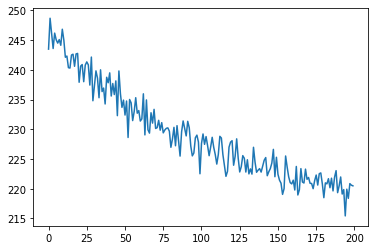

In [19]:
plt.plot(cost_list)

In [ ]:
plt.plot(cost_list, c='blue', pred_list, c='red')
#or 
#plt.plot(cost_list, label=trainloss)
#plt.plot(pred_list, label=testloss)
plt.show()

SyntaxError: ignored

### Evaluation

Loading model

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/archives/mel_specs/1_min/checkpointtr0.tar', map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
cost_list = checkpoint['cost_list']
model.cuda()

CNN(
  (bn_init): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(128, eps

In [20]:
y_list = []
pred_list = []
model.eval()
for i, data in enumerate(test_loader):
    x, y = data
    x = x.cuda()
    pred = model(x)
    
    pred = pred.detach().cpu()
    for _p in pred:
          pred_list.append(int(_p.argmax()))
    for _y in y:
          y_list.append(int(_y))
        
    if i % 10 == 0:
        print('Batch processed = ', i)
    

Batch processed =  0
Batch processed =  10
Batch processed =  20


Accuracy calculation

In [21]:
accuracy = np.sum(np.asarray(pred_list)==np.asarray(y_list))/len(y_list)
print(accuracy)

0.34972677595628415


Confusion matrix calculation

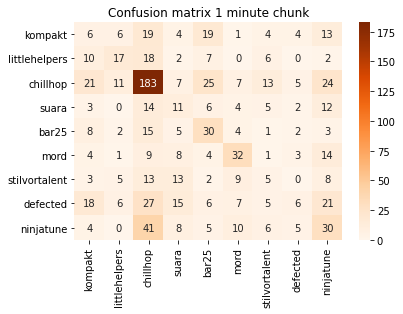

In [25]:
import sklearn.metrics
import seaborn
 
lab = [lab.split('archive')[0] for lab in labels]
plt.figure()
plt.title('Confusion matrix 1 minute chunk')
cm = sklearn.metrics.confusion_matrix(np.asarray(y_list), np.asarray(pred_list))
seaborn.heatmap(cm, annot=True, xticklabels=lab, yticklabels=lab, fmt="d", cmap = "Oranges")

F

In [26]:
sklearn.metrics.f1_score(y_list, pred_list, average='micro')

0.34972677595628415

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_list, pred_list))

              precision    recall  f1-score   support

           0       0.08      0.08      0.08        76
           1       0.35      0.27      0.31        62
           2       0.54      0.62      0.58       296
           3       0.15      0.19      0.17        57
           4       0.29      0.43      0.34        70
           5       0.43      0.42      0.43        76
           6       0.11      0.09      0.10        58
           7       0.22      0.05      0.09       111
           8       0.24      0.28      0.25       109

    accuracy                           0.35       915
   macro avg       0.27      0.27      0.26       915
weighted avg       0.33      0.35      0.33       915

